In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, NullFormatter

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams["axes.labelsize"] = 23
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 28
# mpl.rcParams['text.usetex'] = True # comment out this line if the machine does not have TeX installed
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
datasets = [
    "mscoco_captions", 
    "flickr8k", 
]
models = ['RN50', 'nllb-clip-base', 'ViT-B-32']

num_seeds = 5
out_path = "../output"
sample_sizes = {
    "mscoco_captions": [2, 4, 8, 14, 20],
    "flickr8k": [2, 4, 8, 14, 20],
}

model_names = {
    'RN50': 'ResNet50', 
    'nllb-clip-base': 'NLLB-CLIP', 
    'ViT-B-32': 'ViT-B/32'
}

data_names = {
    "mscoco_captions": "MSCOCO",
    "flickr8k": "Flickr-8k",
}

color1 = "indigo"
color5 = "darkgoldenrod"

In [7]:
def load_result(dataset, model, sample_size, seed):
    templates = f"{dataset}/sample_size_{sample_size:02d}_seed_{seed}_retrieval"
    with open(os.path.join(out_path, f"{model}/{templates}.json"), 'r') as f:
        result = json.load(f)
    return result['metrics']['image_retrieval_recall@5'], result['metrics']['text_retrieval_recall@5']

# def load_baseline(dataset, model):
#     with open(os.path.join(out_path, f"{model}/{dataset}/templates.json"), 'r') as f:
#         result = json.load(f)
#     return result["metrics"]["acc1"], result["metrics"]["acc5"]

def create_ax(ax, dataset, model, linewidth=3, zscore=1.96, capsize=4, s=5):
    ns = np.array(sample_sizes[dataset])
    acc_img = np.zeros(shape=(len(ns), num_seeds))
    acc_txt = np.zeros(shape=(len(ns), num_seeds))
    for i, n in enumerate(ns):
        for j, seed in enumerate(range(num_seeds)):
            acc_img[i, j], acc_txt[i, j] = load_result(dataset, model, n, seed)
    # for j, seed in enumerate(range(num_seeds)):
    #     ax.plot(ns, acc1[:, j], color=color1, alpha=0.5, linewidth=0.5)
    #     ax.plot(ns, acc5[:, j], color=color5, alpha=0.5, linewidth=0.5)

    # llm lines
    ax.errorbar(
        ns, 
        acc_img.mean(axis=1), 
        yerr=zscore * acc_img.std(axis=1), 
        color=color1, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt=".-",
        markersize=2 * s,
        label="Image Retrieval"
    )
    ax.errorbar(
        ns, 
        acc_txt.mean(axis=1), 
        yerr=zscore * acc_txt.std(axis=1), 
        color=color5, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt="s-",
        markersize=s,
        label="Text Retrieval"
    )
    # template lines
    # acc1_base, acc5_base = load_baseline(dataset, model)
    # ax.hlines(y=acc1_base, xmin=ns.min(), xmax=ns.max(), linestyle="dotted", linewidth=1.5 * linewidth, color=color1, label="Top-1 (Templates)")
    # ax.hlines(y=acc5_base, xmin=ns.min(), xmax=ns.max(), linestyle="dotted", linewidth=1.5 * linewidth, color=color5, label="Top-5 (Templates)")


In [11]:
seed = 0
model = "RN50"
ns = [2, 4, 8, 14, 20]
dataset = "flickr8k"

for n in ns:
    acc1, acc2 = load_result(dataset, model, n, seed)
    print(acc1)

0.5741999745368958
0.5741999745368958
0.5741999745368958
0.5741999745368958
0.5741999745368958


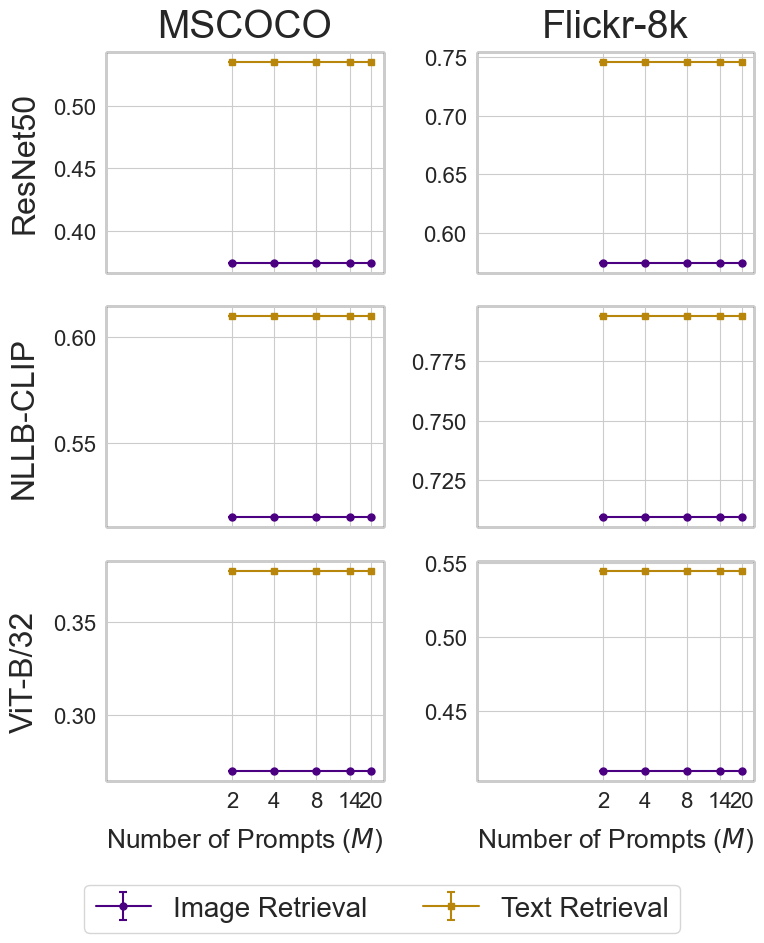

In [9]:
sns.set_style("whitegrid")

scale = 4
linewidth = 1.5
capsize = 3
fig, axes = plt.subplots(len(models), len(datasets), figsize=(scale * len(datasets), 0.75 * scale * len(models)), sharex="col")

for i, model in enumerate(models):
    axes[i, 0].set_ylabel(model_names[model], labelpad=10)
    for j, dataset in enumerate(datasets):
        axes[i, j].patch.set_edgecolor('black')  
        axes[i, j].patch.set_linewidth(1)  
        if i == 0:
            axes[i, j].set_title(data_names[dataset], y=1.03)
        if i == len(models) - 1:
            axes[i, j].set_xlabel(r"Number of Prompts ($M$)", labelpad=10, fontsize=19)
        create_ax(axes[i, j], dataset, model, linewidth=linewidth, capsize=capsize)
        axes[i, j].set_xscale("log")
        axes[i, j].set_xticks(sample_sizes[dataset])

        # Fix formatting for column j=4 (last column)
        if j == 4:
            axes[i, j].xaxis.set_major_formatter(ScalarFormatter())  # Enforce decimal notation
            axes[i, j].ticklabel_format(style="plain", axis="x")  # Disable scientific notation
            axes[i, j].set_xticklabels([f"{M:d}" for M in sample_sizes[dataset]], rotation=0)

            # **Remove minor ticks & labels to prevent duplicates**
            axes[i, j].xaxis.set_minor_formatter(NullFormatter())  # Remove minor ticks
            axes[i, j].xaxis.set_tick_params(which='both', length=5)  # Ensure ticks appear normal

        else:
            axes[i, j].set_xticklabels([f"{M:d}" for M in sample_sizes[dataset]])

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=4)

plt.tight_layout(pad=2.0)
# plt.savefig("../figures/class_conditional_prompting.pdf", bbox_inches="tight")
plt.show()